# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

In [75]:
import pandas as pd 
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split



---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [3]:
# Your code here
boston_data = pd.read_csv('../data/boston_data.csv')

In [4]:
boston_data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [5]:
boston_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 14 columns):
crim       404 non-null float64
zn         404 non-null float64
indus      404 non-null float64
chas       404 non-null float64
nox        404 non-null float64
rm         404 non-null float64
age        404 non-null float64
dis        404 non-null float64
rad        404 non-null float64
tax        404 non-null float64
ptratio    404 non-null float64
black      404 non-null float64
lstat      404 non-null float64
medv       404 non-null float64
dtypes: float64(14)
memory usage: 44.3 KB


In [74]:
boston_data.shape

(404, 14)


    CRIM - per capita crime rate by town
    ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
    INDUS - proportion of non-retail business acres per town.
    CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    NOX - nitric oxides concentration (parts per 10 million)
    RM - average number of rooms per dwelling
    AGE - proportion of owner-occupied units built prior to 1940
    DIS - weighted distances to five Boston employment centres
    RAD - index of accessibility to radial highways
    TAX - full-value property-tax rate per 10000
    PTRATIO - pupil-teacher ratio by town
    B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    LSTAT - % lower status of the population
    MEDV - Median value of owner-occupied homes in 1000's


In [95]:
boston_data.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [96]:
"""Deleting outliers"""

z_score = np.abs(stats.zscore(boston_data))
print(z_score)

boston_reduced = boston_data[(z_score<3).all(axis=1)]
boston_reduced.shape

[[0.39988956 0.47714971 0.05581469 ... 0.23175972 0.39310312 0.06938262]
 [0.40610035 0.65785078 0.89031483 ... 0.44326188 0.48852577 0.30731398]
 [0.3785481  0.47714971 0.18951101 ... 0.43626832 0.38009094 0.22800353]
 ...
 [0.41598186 3.60885208 1.46623746 ... 0.42863899 1.36467925 3.13702567]
 [0.41536167 3.38185198 1.53528941 ... 0.44326188 0.98732602 0.27051932]
 [0.40843331 0.88485088 0.91969864 ... 0.25793258 0.90202395 0.15721867]]


(321, 14)

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

In [97]:
boston_reduced.corr()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
crim,1.000000,-0.245049,0.523523,NaN,0.562803,-0.199660,0.436390,-0.485358,0.811224,0.749920,0.344787,-0.327797,0.563541,-0.504009
zn,-0.245049,1.000000,-0.467428,NaN,-0.444377,0.295135,-0.453536,0.559321,-0.245867,-0.265426,-0.350184,0.148885,-0.365562,0.342641
indus,0.523523,-0.467428,1.000000,NaN,0.721443,-0.362448,0.562405,-0.659449,0.569357,0.705728,0.327299,-0.324725,0.613879,-0.565210
chas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nox,0.562803,-0.444377,0.721443,NaN,1.000000,-0.274451,0.705628,-0.762902,0.581103,0.642956,0.119749,-0.349625,0.589708,-0.467456
rm,-0.199660,0.295135,-0.362448,NaN,-0.274451,1.000000,-0.194372,0.190069,-0.111475,-0.206632,-0.232715,0.107586,-0.613583,0.712762
age,0.436390,-0.453536,0.562405,NaN,0.705628,-0.194372,1.000000,-0.695878,0.402581,0.466754,0.195327,-0.234018,0.605873,-0.454210
dis,-0.485358,0.559321,-0.659449,NaN,-0.762902,0.190069,-0.695878,1.000000,-0.454150,-0.518759,-0.182534,0.265998,-0.495526,0.314168
rad,0.811224,-0.245867,0.569357,NaN,0.581103,-0.111475,0.402581,-0.454150,1.000000,0.902493,0.424147,-0.321713,0.456052,-0.425741
tax,0.749920,-0.265426,0.705728,NaN,0.642956,-0.206632,0.466754,-0.518759,0.902493,1.000000,0.422950,-0.340601,0.529352,-0.535400


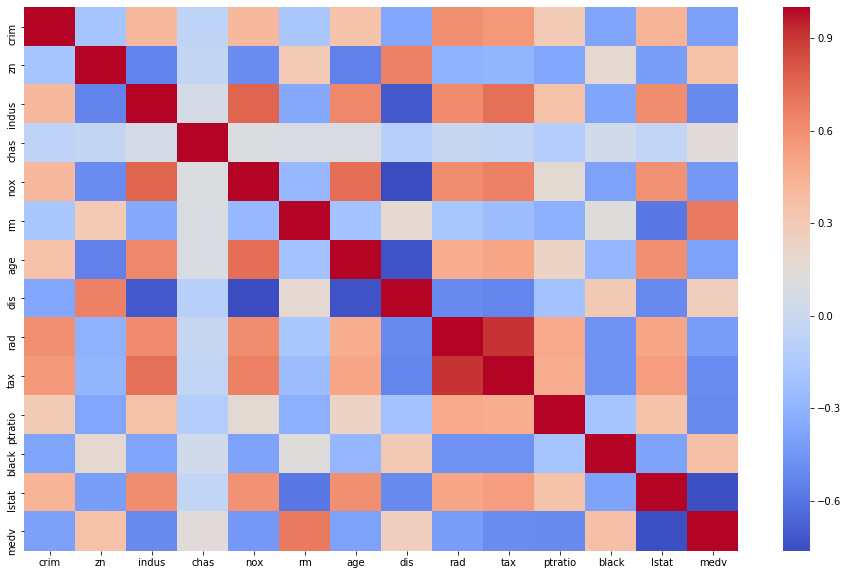

In [98]:
# Your plots here
plt.figure(figsize=(16,10))
sns.heatmap(boston_data.corr(), cmap='coolwarm')

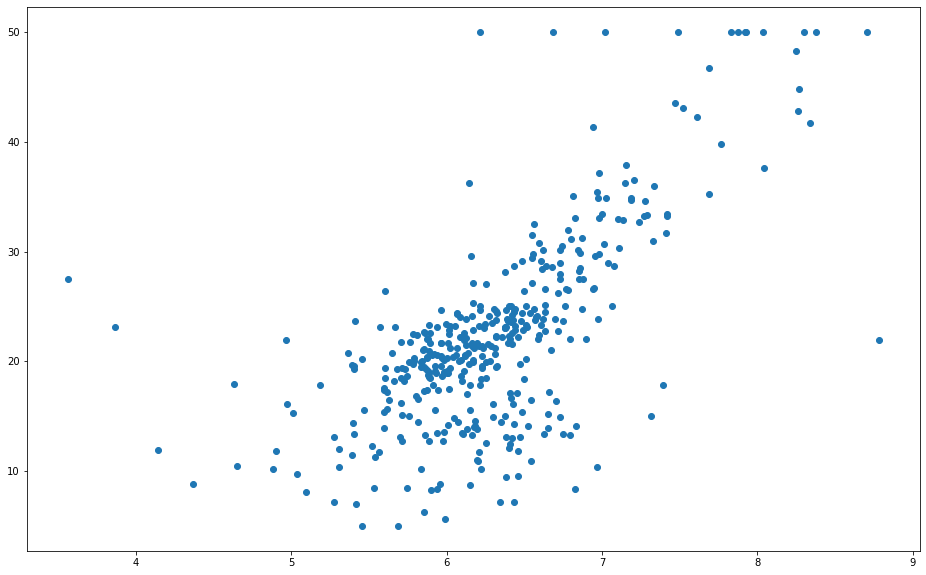

In [99]:
plt.figure(figsize=(16,10))
plt.scatter(boston_data['rm'], boston_data['medv'])

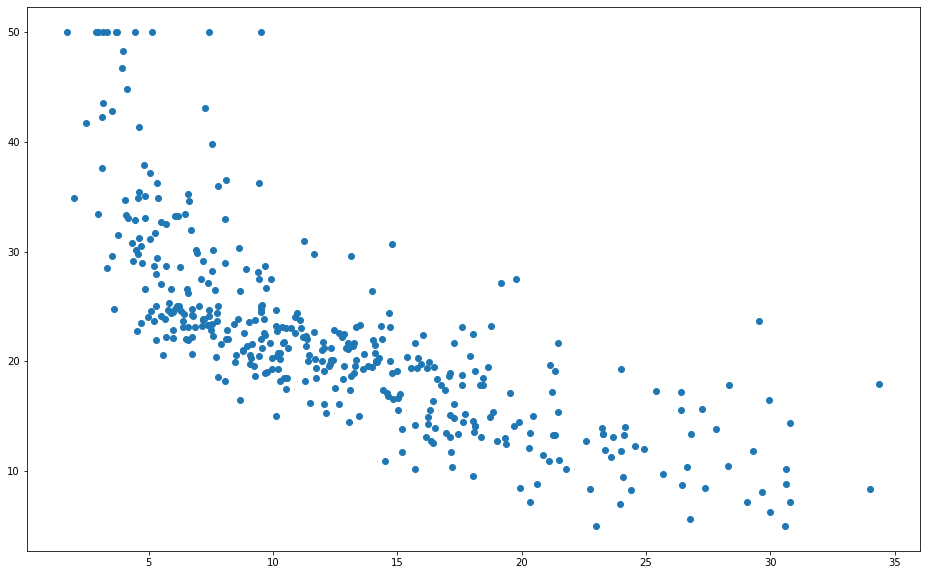

In [100]:
plt.figure(figsize=(16,10))
plt.scatter(boston_data['lstat'],boston_data['medv'])

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [101]:
# Your response here
"""
The most correlated variable is the average number of rooms per dwelling.
The prices is negative correlated with the lower status of the population
"""

'\nThe most correlated variable is the average number of rooms per dwelling.\nThe prices is negative correlated with the lower status of the population\n'

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

In [102]:
# Your response here
"""
The variable chas is not correlated with prices
"""

'\nThe variable chas is not correlated with prices\n'

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [103]:
# Your code here
boston_data.describe()['medv']

count    404.000000
mean      22.312376
std        8.837019
min        5.000000
25%       17.100000
50%       21.400000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [104]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    return r2_score(y_true, y_predict)
    

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [105]:
# Your code here
X_train, X_test, y_train, y_test = train_test_split(boston_data.drop('medv', axis =1), boston_data['medv'], test_size = 0.2, shuffle = True, random_state = 42)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

In [106]:
from sklearn.ensemble import RandomForestRegressor

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [113]:
# Five separate RFR here with the given max depths
depth_list = np.arange(2,11,2)
rfr_list = [RandomForestRegressor(n_estimators = 10, max_depth = i).fit(X_train, y_train) for i in depth_list]
score_train = [performance_metric(y_train, rfr.predict(X_train)) for rfr in rfr_list]
score_test = [performance_metric(y_test, rfr.predict(X_test)) for rfr in rfr_list]


Now, plot the score for each tree on the training set and on the testing set.

In [114]:
# Produce a plot with the score for the testing and training for the different max depths
fig = go.Figure(data=[
    go.Scatter(x = depth_list, y= score_train, name='score_train'),
    go.Scatter(x = depth_list, y= score_test, name = 'score_test')
])
fig.show()

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [ ]:
# Your response here

"""
When increase the max depth, at some point it stops to improve because overfitting
"""

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

In [ ]:
# Your response here

"""
When the model is trained with a maximum depth of 1, the model suffer from high bias, the algorithm miss relevant relations
between the feautres and the target (underfitting)

When the model is trained with a big depth, the model suffer from high variance, the algorithm model the noise from
the training set (overfitting)
"""

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [135]:
# Your response here

"""
Each time I run the RFR I got different results, I make a simulation for see which one do better overall
"""
depth_list = np.arange(1,16)

number_simulations = 3000
simulation_result = np.zeros(15)

for i in np.arange(number_simulations):
    rfr_list = [RandomForestRegressor(n_estimators = 10, max_depth = i).fit(X_train, y_train) for i in depth_list]
    simulation_result += np.array([performance_metric(y_test, rfr.predict(X_test)) for rfr in rfr_list])

simulation_result /= number_simulations

In [138]:
print(simulation_result)

"""
It looks that the best result is for max_depth = 11
"""

[0.37840819 0.58662347 0.63464924 0.6541773  0.67651337 0.68940932
 0.69485772 0.69868963 0.69831088 0.69807663 0.70003569 0.69943291
 0.69893891 0.69911053 0.69798867]


'\nIt looks that the best result is for max_depth = 11\n'

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*